In [1]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import time
import seaborn as sns

Using TensorFlow backend.


In [2]:
start_time = time.time()
df = pd.read_csv("bio_data_temp.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 35 columns):
OD_START        149 non-null float64
AN_START        149 non-null float64
AGE_1F          149 non-null float64
OD_1F           149 non-null float64
AN_1F           149 non-null float64
(NH4)2SO4_1F    149 non-null float64
KH2PO4_1F       149 non-null float64
BM_1F           149 non-null float64
CM_1F           149 non-null float64
Sucrose_1F      149 non-null float64
Betaine_1F      149 non-null float64
ACC_SUGAR_2F    149 non-null float64
AGE_2F          149 non-null float64
OD_2F           149 non-null float64
AN_2F           149 non-null float64
(NH4)2SO4_2F    149 non-null float64
KH2PO4_2F       149 non-null float64
BM_2F           149 non-null float64
CM_2F           149 non-null float64
Sucrose_2F      149 non-null float64
Betaine_2F      149 non-null float64
SOD             149 non-null float64
Glucose         149 non-null float64
ACC_SUGAR_1M    149 non-null float64
AGE_1M 

이상치 제거 (outlier) 

높은 차원이므로 isolation forest를 사용한다

In [3]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest( random_state=1)

clf.fit(df)

y_pred_outliers = clf.predict(df)


out = pd.DataFrame(y_pred_outliers)
out = out.rename(columns={0: "out"})
data = pd.concat([df, out], 1)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [4]:
data.drop('out',axis=1,inplace= True)

정규화

In [5]:
from sklearn import preprocessing
data_x = data[['OD_START', 'AN_START', 'AGE_1F', 'OD_1F', 'AN_1F', '(NH4)2SO4_1F',
       'KH2PO4_1F', 'BM_1F', 'CM_1F', 'Sucrose_1F', 'Betaine_1F',
       'ACC_SUGAR_2F', 'AGE_2F', 'OD_2F', 'AN_2F', '(NH4)2SO4_2F', 'KH2PO4_2F',
       'BM_2F', 'CM_2F', 'Sucrose_2F', 'Betaine_2F', 'SOD', 'Glucose',
       'ACC_SUGAR_1M', 'AGE_1M', 'OD_1M', 'AN_1M', 'MBO_VOL', '(NH4)2SO4_1M',
       'KH2PO4_1M', 'BM_1M', 'CM_1M', 'Sucrose_1M', 'Betaine_1M']]

df_norm = (data_x - data_x.min()) / (data_x.max() - data_x.min())

df_norm.fillna(0,inplace=True)
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 34 columns):
OD_START        149 non-null float64
AN_START        149 non-null float64
AGE_1F          149 non-null float64
OD_1F           149 non-null float64
AN_1F           149 non-null float64
(NH4)2SO4_1F    149 non-null float64
KH2PO4_1F       149 non-null float64
BM_1F           149 non-null float64
CM_1F           149 non-null float64
Sucrose_1F      149 non-null float64
Betaine_1F      149 non-null float64
ACC_SUGAR_2F    149 non-null float64
AGE_2F          149 non-null float64
OD_2F           149 non-null float64
AN_2F           149 non-null float64
(NH4)2SO4_2F    149 non-null float64
KH2PO4_2F       149 non-null float64
BM_2F           149 non-null float64
CM_2F           149 non-null float64
Sucrose_2F      149 non-null float64
Betaine_2F      149 non-null float64
SOD             149 non-null float64
Glucose         149 non-null float64
ACC_SUGAR_1M    149 non-null float64
AGE_1M 

아웃라이어 제거 및 정규화 후 배지 구성성분 부분에서 0값이 많음

차원 축소 -> 차원의 저주, 모델이 복잡해지고 overfitting해질 확률이 높음

In [6]:
data.head()

,OD_START,AN_START,AGE_1F,OD_1F,AN_1F,(NH4)2SO4_1F,KH2PO4_1F,BM_1F,CM_1F,Sucrose_1F,...,OD_1M,AN_1M,MBO_VOL,(NH4)2SO4_1M,KH2PO4_1M,BM_1M,CM_1M,Sucrose_1M,Betaine_1M,FBO_AGE
0,15.940000,1.72,1.566667,24.580000,1.16,8.00,0.0,6.0,38.3,363.6,...,57.939999,0.491,3.0,4.05,0.0,10.47,0.0,10.71,0.0,22.42
1,16.110001,1.64,1.566667,24.780001,1.13,8.00,0.0,6.0,38.3,363.6,...,59.639999,0.647,2.6,4.05,0.0,10.47,0.0,10.71,0.0,21.77
2,16.209999,1.68,1.600000,24.410000,1.09,8.00,0.0,6.0,38.3,363.6,...,59.599998,0.984,2.6,4.05,0.0,10.47,0.0,10.71,0.0,32.25
3,15.820000,1.62,1.700000,24.629999,1.10,8.00,0.0,6.0,38.3,363.6,...,62.600000,0.630,2.6,4.05,0.0,10.47,0.0,10.71,0.0,26.92
4,16.299999,1.82,1.333333,22.400000,1.29,41.23,0.0,6.0,38.3,363.6,...,58.100000,1.200,3.0,4.05,0.0,10.47,0.0,10.71,0.0,23.62


In [7]:
norm_data = pd.concat([df_norm, data[['FBO_AGE']]], axis =1)

In [8]:
norm_data.corr()['FBO_AGE'].abs().sort_values().tail(8)

AGE_2F          0.334959
MBO_VOL         0.340497
AN_START        0.370554
AGE_1M          0.426262
ACC_SUGAR_1M    0.433436
Glucose         0.437038
ACC_SUGAR_2F    0.462436
FBO_AGE         1.000000
Name: FBO_AGE, dtype: float64

In [9]:
corr_data = norm_data[norm_data.corr()['FBO_AGE'].abs().sort_values().tail(9).index]
corr_data.drop('FBO_AGE', axis = 1,inplace = True)
corr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 8 columns):
AGE_1F          149 non-null float64
AGE_2F          149 non-null float64
MBO_VOL         149 non-null float64
AN_START        149 non-null float64
AGE_1M          149 non-null float64
ACC_SUGAR_1M    149 non-null float64
Glucose         149 non-null float64
ACC_SUGAR_2F    149 non-null float64
dtypes: float64(8)
memory usage: 9.4 KB


C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


상관관계

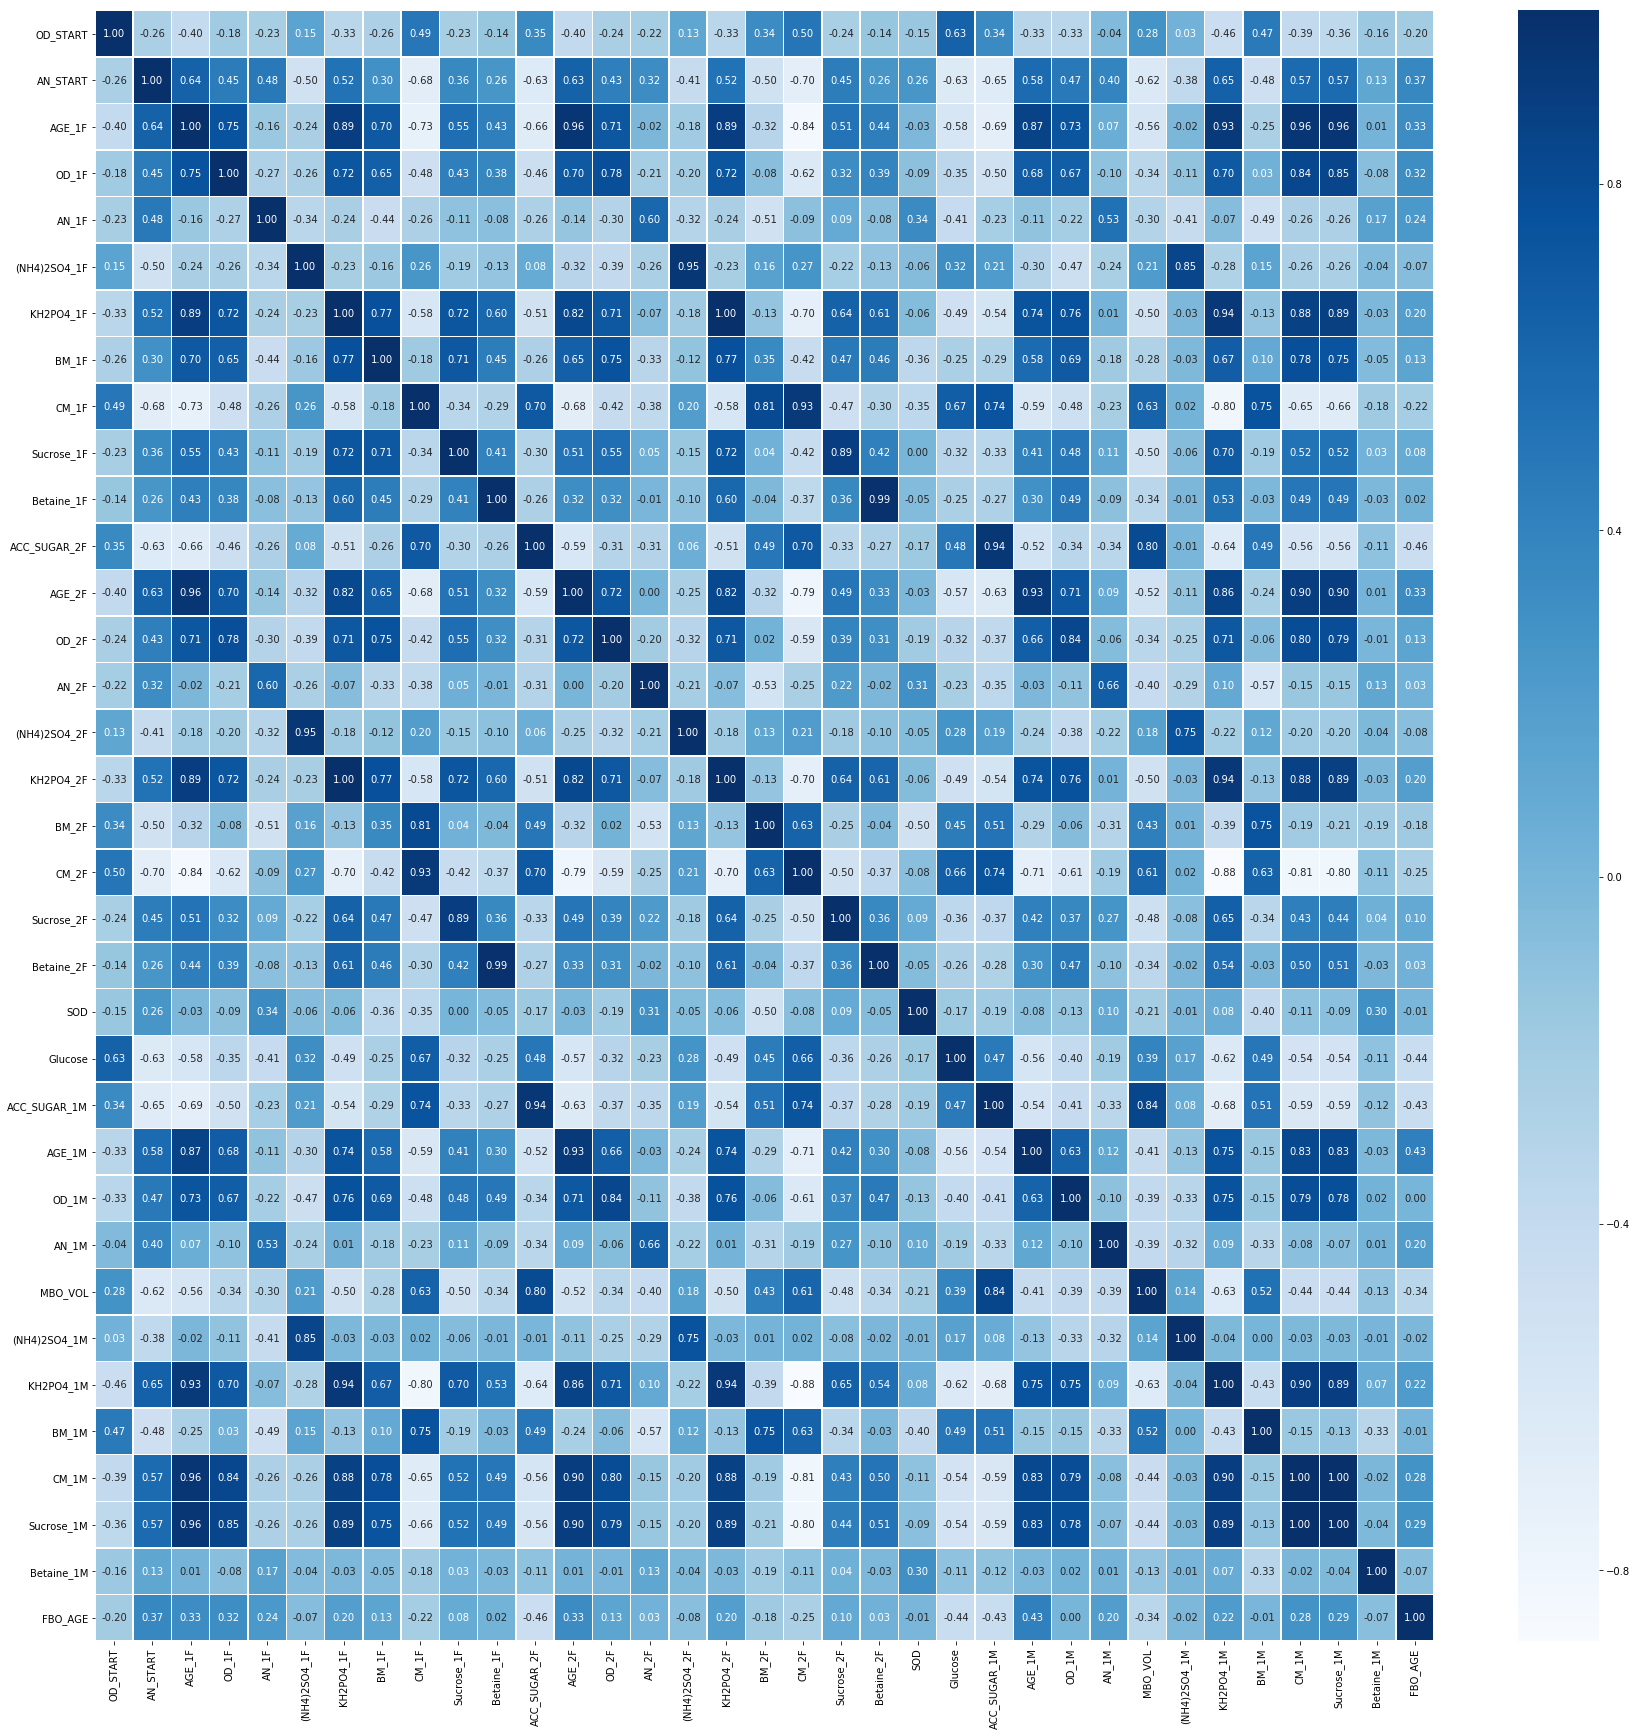

In [10]:
plt.figure(figsize=(30,30))
sns.heatmap(data = norm_data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [11]:
train_stats = norm_data.describe()
train_stats.pop("FBO_AGE")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
OD_START,149.0,0.636689,0.185381,0.0,0.536976,0.640603,0.763542,1.0
AN_START,149.0,0.386205,0.225325,0.0,0.272308,0.416923,0.569231,1.0
AGE_1F,149.0,0.256884,0.274310,0.0,0.073569,0.111717,0.324251,1.0
OD_1F,149.0,0.503056,0.168551,0.0,0.402555,0.438939,0.511709,1.0
AN_1F,149.0,0.415317,0.275060,0.0,0.287958,0.379581,0.586387,1.0
(NH4)2SO4_1F,149.0,0.100700,0.180175,0.0,0.011074,0.039865,0.132883,1.0
KH2PO4_1F,149.0,0.195179,0.369490,0.0,0.000000,0.000000,0.100000,1.0
BM_1F,149.0,0.532248,0.279942,0.0,0.436132,0.455940,0.503229,1.0
CM_1F,149.0,0.699469,0.370661,0.0,0.312063,0.945170,0.985865,1.0
Sucrose_1F,149.0,0.763154,0.147273,0.0,0.692164,0.738136,0.766559,1.0


데이터셋 학습, 테스트 나누기

In [12]:
from sklearn.model_selection import train_test_split

X = norm_data[['OD_START', 'AN_START', 'AGE_1F', 'OD_1F', 'AN_1F', '(NH4)2SO4_1F',
       'KH2PO4_1F', 'BM_1F', 'CM_1F', 'Sucrose_1F', 'Betaine_1F',
       'ACC_SUGAR_2F', 'AGE_2F', 'OD_2F', 'AN_2F', '(NH4)2SO4_2F', 'KH2PO4_2F',
       'BM_2F', 'CM_2F', 'Sucrose_2F', 'Betaine_2F', 'SOD', 'Glucose',
       'ACC_SUGAR_1M', 'AGE_1M', 'OD_1M', 'AN_1M', 'MBO_VOL', '(NH4)2SO4_1M',
       'KH2PO4_1M', 'BM_1M', 'CM_1M', 'Sucrose_1M', 'Betaine_1M']]

y = norm_data['FBO_AGE']

X_train = X

y_train = y

X_orig = data[['OD_START', 'AN_START', 'AGE_1F', 'OD_1F', 'AN_1F', '(NH4)2SO4_1F',
       'KH2PO4_1F', 'BM_1F', 'CM_1F', 'Sucrose_1F', 'Betaine_1F',
       'ACC_SUGAR_2F', 'AGE_2F', 'OD_2F', 'AN_2F', '(NH4)2SO4_2F', 'KH2PO4_2F',
       'BM_2F', 'CM_2F', 'Sucrose_2F', 'Betaine_2F', 'SOD', 'Glucose',
       'ACC_SUGAR_1M', 'AGE_1M', 'OD_1M', 'AN_1M', 'MBO_VOL', '(NH4)2SO4_1M',
       'KH2PO4_1M', 'BM_1M', 'CM_1M', 'Sucrose_1M', 'Betaine_1M']]

y_orig = data['FBO_AGE']

x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(X, y, test_size=0.1, random_state=5)
x_train, x_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.1, random_state=5)

x_train_corr, x_test_corr, y_train_corr, y_test_corr = train_test_split(corr_data, y_orig, test_size=0.1, random_state=5)

## PCA 사용후 

95% PCA 데이터 셋

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)


x_reduced = pca.fit_transform(x_train_norm)
x_reduced_test = pca.transform(x_test_norm)
x_reduced.shape

(134, 11)

Linear Regression - PCA 95%

In [14]:
start = time.time()

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x_reduced, y_train_norm)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


y_predicted= lin_reg.predict(x_reduced_test)

In [15]:
y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca1 - linear regression time :", time.time() - start)


0.21335683288937154
pca1 - linear regression time : 0.022938966751098633


Random Forest Regressor

In [16]:
# Random Forest Regressor
start = time.time()
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import GridSearchCV
 
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
 
grid_search.fit(x_reduced, y_train_norm)
grid_search.best_params_

y_predicted= grid_search.predict(x_reduced_test)

y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
np.array(score).mean()
print(np.array(score).mean())
print("pca1 - random forest time :", time.time() - start)

0.12121366625123671
pca1 - random forest time : 1.5142319202423096


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVR

In [17]:
from sklearn.svm import SVR
start = time.time()
svm_model = SVR(kernel='poly', C=1.0, gamma='auto') 

svm_model.fit(x_reduced, y_train_norm)

y_predicted= svm_model.predict(x_reduced_test)

y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
np.array(score).mean()
print(np.array(score).mean())
print("pca1 - svr time :", time.time() - start)

0.22963585357220176
pca1 - svr time : 0.003955364227294922


## PCA 2 - 90%

In [18]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=0.90)


x_reduced2 = pca2.fit_transform(x_train_norm)
x_reduced_test2 = pca2.transform(x_test_norm)
x_reduced2.shape

(134, 7)

Linear Regression

In [19]:
start = time.time()

lin_reg2 = LinearRegression()
lin_reg2.fit(x_reduced2, y_train)


y_predicted= lin_reg2.predict(x_reduced_test2)

In [20]:
y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca2 - linear regression time :", time.time() - start)

0.2126816844743432
pca2 - linear regression time : 0.016955137252807617


Random Forest

In [21]:
# Random Forest Regressor
start = time.time()
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
 
grid_search2 = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
 
grid_search2.fit(x_reduced2, y_train_norm)

y_predicted= grid_search2.predict(x_reduced_test2)

y_trest_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
np.array(score).mean()
print(np.array(score).mean())
print("pca2 - random forest time :", time.time() - start)

0.14431455116290026
pca2 - random forest time : 1.4784114360809326


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVR

In [22]:
from sklearn.svm import SVR
start = time.time()
svm_model2 = SVR(kernel='poly', C=1.0, gamma='auto') 

svm_model2.fit(x_reduced2, y_train_norm)

y_predicted= svm_model2.predict(x_reduced_test2)

y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca2 - svr time :", time.time() - start)

0.2261691023817432
pca2 - svr time : 0.0


정규화된 34개 변수

Linear Regression

In [23]:
start = time.time()

lin_reg3 = LinearRegression()
lin_reg3.fit(x_train_norm,y_train_norm)


y_predicted= lin_reg3.predict(x_test_norm)
y_predicted

array([46.14484658, 38.37946637, 42.14664428, 33.21818516, 37.07309197,
       37.59124323, 25.3111404 , 39.65791645, 27.10767017, 14.68151745,
       32.14344577, 41.6701676 , 30.06283844, 31.68547961, 32.1482658 ])

In [24]:
y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x - linear regression time :", time.time() - start)

0.20386202082907248
pca x - linear regression time : 0.015621662139892578


random forest

In [25]:
# Random Forest Regressor
start = time.time() 
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6,10,15,20]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
 
grid_search3 = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
 
grid_search3.fit(x_train_norm, y_train_norm)

y_predicted= grid_search3.predict(x_test_norm)


y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x - random forest time :", time.time() - start)

0.12729439973081264
pca x - random forest time : 2.4546494483947754


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


svr

In [26]:
from sklearn.svm import SVR
start = time.time() 
svm_model3 = SVR(kernel='poly', C=1.0, gamma='auto') 

svm_model3.fit(x_train_norm,y_train_norm)

y_predicted= svm_model3.predict(x_test_norm)

y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x - svr time :", time.time() - start)

0.2302489607562922
pca x - svr time : 0.007978439331054688


most correlated 8개 변수

linear regression

In [27]:
start = time.time() 

lin_reg3 = LinearRegression()
lin_reg3.fit(x_train_corr, y_train_corr)


y_predicted= lin_reg3.predict(x_test_corr)

y_test_array = np.array(y_test_corr)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("8 var - linear regression time :", time.time() - start)

0.20932279016950187
8 var - linear regression time : 0.005984067916870117


In [ ]:
random forest regressor

In [28]:
# Random Forest Regressor
start = time.time() 
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6,8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
 
grid_search3 = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
 
grid_search3.fit(x_train_corr, y_train_corr)

y_predicted= grid_search3.predict(x_test_corr)


y_test_array = np.array(y_test_corr)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("8 var - random forest time :", time.time() - start)

0.13051043605155355
8 var - random forest time : 1.9663219451904297


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


svr

In [29]:
from sklearn.svm import SVR
start = time.time() 
svm_model3 = SVR(kernel='poly', C=1.0, gamma='auto') 

svm_model3.fit(x_train_corr,y_train_corr)

y_predicted= svm_model3.predict(x_test_corr)

y_test_array = np.array(y_test_corr)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("8 var - svr time :", time.time() - start)

0.22804899653607433
8 var - svr time : 0.005985736846923828


기존 34개 변수

linear regression

In [30]:
start = time.time() 
lin_reg4 = LinearRegression()
lin_reg4.fit(x_train,y_train)


y_predicted= lin_reg4.predict(x_test)

In [31]:
score = []
y_test_array = np.array(y_test)
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x norm x - linear regression time :", time.time() - start)

0.2038620208290627
pca x norm x - linear regression time : 0.015954971313476562


random forest

In [32]:
# Random Forest Regressor
start = time.time()  
param_grid = [
        {'n_estimators': [3, 10, 15], 'max_features': [2, 4, 6,10,15,20]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
 
grid_search4 = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
 
grid_search4.fit(x_train, y_train)

print(grid_search4.best_params_)

y_predicted= grid_search4.predict(x_test)
y_test_array = np.array(y_test)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x norm x - random forest time :", time.time() - start)

{'max_features': 20, 'n_estimators': 10}
0.1395502077847915
pca x norm x - random forest time : 2.0966975688934326


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


svr

In [33]:
from sklearn.svm import SVR
start = time.time()
svm_model4 = SVR(kernel='poly', C=1.0, gamma='auto') 

svm_model4.fit(x_train,y_train)

y_predicted= svm_model4.predict(x_test)

print(y_predicted)

y_test_array = np.array(y_test)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x norm x -svr time :", time.time() - start)

[   33982.57776742  -789751.58382315    64832.67340951  -122167.5458898
   209557.99927621  -109311.4722814     43271.43628793 -3874879.56261344
   133401.64014535  -470148.59117789   112670.29944711   481542.42310434
    83179.5667811     23928.59436899   -83106.45781607]
13211.829304067915
pca x norm x -svr time : 108.55509233474731


# ---------------------------------------------------------------------------------------------------------

neural network

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model

In [35]:
def build_model(input_dim):
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[input_dim]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error'])
  return model

pca 95%

In [36]:
start = time.time()
model_pca = build_model(x_reduced.shape[1])
model_pca.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,313
Trainable params: 13,313
Non-trainable params: 0
_________________________________________________________________


In [37]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model_pca.fit(
  x_reduced, y_train_norm,
  epochs=EPOCHS, batch_size = 20,validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
0,35.299753,35.299751,34.659916,34.659916,0
1,34.843576,34.843578,34.183067,34.183067,1
2,34.181325,34.181328,33.360756,33.360756,2
3,33.074717,33.074718,31.898649,31.898649,3
4,31.036211,31.036211,29.226011,29.226011,4


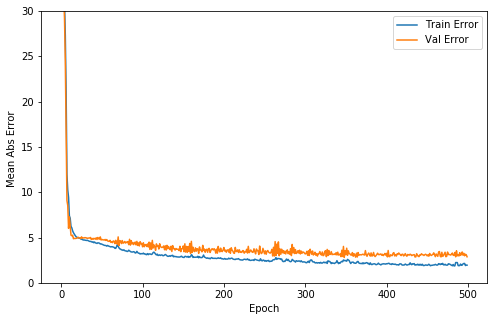

In [39]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,5))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()


plot_history(history)

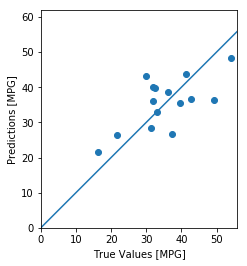

In [40]:
y_predicted = model_pca.predict(x_reduced_test).flatten()

plt.scatter(y_test_norm, y_predicted)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [41]:

y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca 95  - nn time :", time.time() - start)

0.18072189252694518
pca 95  - nn time : 20.327519416809082


PCA 90%

In [42]:
start = time.time()
model_pca2 = build_model(x_reduced2.shape[1])
model_pca2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


In [43]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model_pca2.fit(
  x_reduced2, y_train_norm,
  epochs=EPOCHS, batch_size = 20,validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [44]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
0,35.346848,35.346848,34.765190,34.765190,0
1,35.051753,35.051754,34.393929,34.393929,1
2,34.591869,34.591869,33.729275,33.729275,2
3,33.777545,33.777546,32.525459,32.525459,3
4,32.269108,32.269108,30.347227,30.347227,4


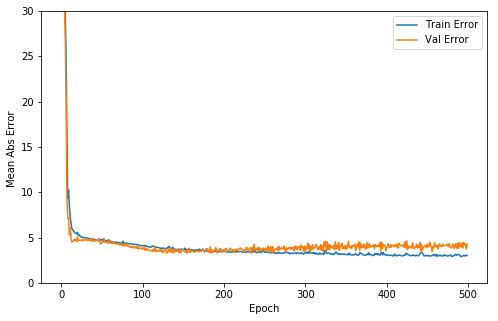

In [45]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,5))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()


plot_history(history)

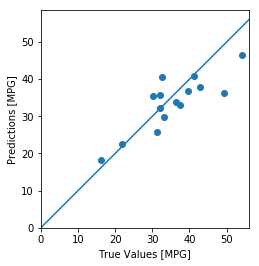

In [46]:
y_predicted = model_pca2.predict(x_reduced_test2).flatten()

plt.scatter(y_test_norm, y_predicted)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [47]:

y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca 90  - nn time :", time.time() - start)

0.1189041332230385
pca 90  - nn time : 27.203784942626953


정규화된 34개변수

In [48]:
start = time.time()
model_no_pca = build_model(x_train_norm.shape[1])
model_no_pca.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                2240      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 14,785
Trainable params: 14,785
Non-trainable params: 0
_________________________________________________________________


In [49]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model_no_pca.fit(
  x_train_norm, y_train_norm,
  epochs=EPOCHS, batch_size = 20,validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [50]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
0,35.110830,35.110832,34.352509,34.352509,0
1,34.382155,34.382156,33.449608,33.449608,1
2,33.147280,33.147282,31.769148,31.769148,2
3,30.704755,30.704754,28.413321,28.413321,3
4,25.940247,25.940247,21.738722,21.738722,4


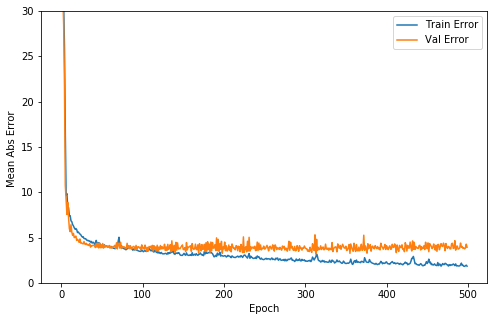

In [51]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,5))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()


plot_history(history)

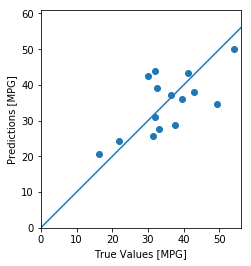

In [52]:
y_predicted = model_no_pca.predict(x_test_norm).flatten()

plt.scatter(y_test_norm, y_predicted)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [53]:

y_test_array = np.array(y_test_norm)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x  - nn time :", time.time() - start)

0.17629926400461254
pca x  - nn time : 25.63888382911682


most correlated 8개 변수

In [54]:
start = time.time()
model_corr = build_model(x_train_corr.shape[1])
model_corr.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


In [55]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model_corr.fit(
  x_train_corr, y_train_corr,
  epochs=EPOCHS, batch_size = 20,validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
0,35.331161,35.331161,34.735680,34.735680,0
1,34.963460,34.963459,34.309414,34.309414,1
2,34.382962,34.382961,33.577309,33.577309,2
3,33.377731,33.377731,32.301563,32.301563,3
4,31.589560,31.589563,29.988955,29.988955,4


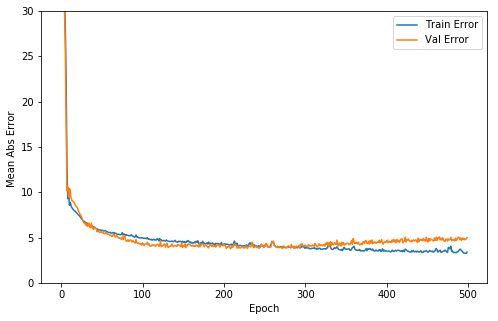

In [57]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,5))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()


plot_history(history)

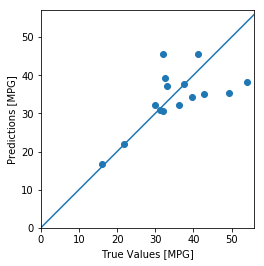

In [58]:
y_predicted = model_corr.predict(x_test_corr).flatten()

plt.scatter(y_test_corr, y_predicted)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [59]:

y_test_array = np.array(y_test_corr)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x  - nn time :", time.time() - start)

0.13717489200747449
pca x  - nn time : 28.81866765022278


기존 34개 변수

In [60]:
start = time.time()
model = build_model(x_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                2240      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 14,785
Trainable params: 14,785
Non-trainable params: 0
_________________________________________________________________


In [61]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model.fit(
  x_train, y_train,
  epochs=EPOCHS, batch_size = 20,validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [62]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
0,21.724317,21.724318,12.834455,12.834455,0
1,12.878767,12.878768,9.709021,9.709021,1
2,10.109180,10.109180,8.553602,8.553602,2
3,8.906034,8.906034,6.874506,6.874506,3
4,8.749289,8.749288,8.533777,8.533777,4


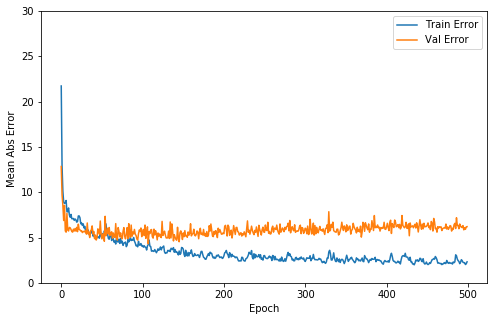

In [63]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,5))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()


plot_history(history)

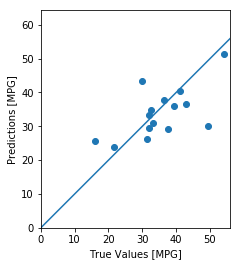

In [64]:
y_predicted = model.predict(x_test).flatten()

plt.scatter(y_test, y_predicted)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [65]:

y_test_array = np.array(y_test)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x norm x  - nn time :", time.time() - start)

0.16725243244990382
pca x norm x  - nn time : 23.49471664428711


cnn

PCA 95

In [66]:
start = time.time()
def build_reduced1(input_dim):
    model = keras.Sequential()
    model.add(layers.Conv1D(64, 2, activation='relu', input_shape = (input_dim,1)))
    model.add(layers.Conv1D(64, 2, activation='relu'))
    model.add(layers.Conv1D(64, 2, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model

In [67]:

model_reduced1 = build_reduced1(x_reduced.shape[1])
model_reduced1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 64)            192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 64)             8256      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 64)             8256      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [68]:
x_reduced = x_reduced.reshape(x_reduced.shape[0],x_reduced.shape[1],1)
history = model_reduced1.fit(x_reduced, y_train,
                    epochs=500,
                    batch_size=20,
                    validation_split=0.1)

x_reduced_test = x_reduced_test.reshape(x_reduced_test.shape[0],x_reduced_test.shape[1],1)
y_predicted = model_reduced1.predict(x_reduced_test).flatten()

y_predicted

Train on 120 samples, validate on 14 samples
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
120/120 [==============================] - 1s 11ms/sample - loss: 35.3487 - mean_absolute_error: 35.3487 - val_loss: 34.7289 - val_mean_absolute_error: 34.7289
Epoch 2/500
120/120 [==============================] - 0s 452us/sample - loss: 34.9870 - mean_absolute_error: 34.9870 - val_loss: 34.2939 - val_mean_absolute_error: 34.2939
Epoch 3/500
120/120 [==============================] - 0s 391us/sample - loss: 34.4573 - mean_absolute_error: 34.4573 - val_loss: 33.5951 - val_mean_absolute_error: 33.5951
Epoch 4/500
120/120 [==============================] - 0s 391us/sample - loss: 33.5741 - mean_absolute_error: 33.5741 - val_loss: 32.3919 - val_mean_absolute_error: 32.3919
Epoch 5/500
120/120 [==============================] - 0s 391us/sample - loss: 32.0673 - mean_absolute_error: 32.0673 - val_loss: 30.3022 - val_mean_absolute_error: 30.3022
Epoch 6/500
1

Epoch 95/500
120/120 [==============================] - 0s 432us/sample - loss: 5.8507 - mean_absolute_error: 5.8507 - val_loss: 4.5755 - val_mean_absolute_error: 4.5755
Epoch 96/500
120/120 [==============================] - 0s 391us/sample - loss: 5.8426 - mean_absolute_error: 5.8426 - val_loss: 4.4108 - val_mean_absolute_error: 4.4108
Epoch 97/500
120/120 [==============================] - 0s 357us/sample - loss: 5.8101 - mean_absolute_error: 5.8101 - val_loss: 4.3418 - val_mean_absolute_error: 4.3418
Epoch 98/500
120/120 [==============================] - 0s 366us/sample - loss: 5.8081 - mean_absolute_error: 5.8081 - val_loss: 4.5693 - val_mean_absolute_error: 4.5693
Epoch 99/500
120/120 [==============================] - 0s 366us/sample - loss: 5.8939 - mean_absolute_error: 5.8939 - val_loss: 4.2635 - val_mean_absolute_error: 4.2635
Epoch 100/500
120/120 [==============================] - 0s 440us/sample - loss: 5.7953 - mean_absolute_error: 5.7953 - val_loss: 4.4224 - val_mean_ab

Epoch 143/500
120/120 [==============================] - 0s 391us/sample - loss: 5.5975 - mean_absolute_error: 5.5975 - val_loss: 4.2691 - val_mean_absolute_error: 4.2691
Epoch 144/500
120/120 [==============================] - 0s 391us/sample - loss: 5.6001 - mean_absolute_error: 5.6001 - val_loss: 4.5110 - val_mean_absolute_error: 4.5110
Epoch 145/500
120/120 [==============================] - 0s 391us/sample - loss: 5.7197 - mean_absolute_error: 5.7197 - val_loss: 4.1780 - val_mean_absolute_error: 4.1780
Epoch 146/500
120/120 [==============================] - 0s 391us/sample - loss: 5.5770 - mean_absolute_error: 5.5770 - val_loss: 4.5489 - val_mean_absolute_error: 4.5489
Epoch 147/500
120/120 [==============================] - 0s 391us/sample - loss: 5.6235 - mean_absolute_error: 5.6235 - val_loss: 4.2021 - val_mean_absolute_error: 4.2021
Epoch 148/500
120/120 [==============================] - 0s 391us/sample - loss: 5.6588 - mean_absolute_error: 5.6588 - val_loss: 4.4011 - val_me

Epoch 191/500
120/120 [==============================] - 0s 260us/sample - loss: 5.2219 - mean_absolute_error: 5.2219 - val_loss: 4.2788 - val_mean_absolute_error: 4.2788
Epoch 192/500
120/120 [==============================] - 0s 391us/sample - loss: 5.2057 - mean_absolute_error: 5.2057 - val_loss: 4.4492 - val_mean_absolute_error: 4.4492
Epoch 193/500
120/120 [==============================] - 0s 391us/sample - loss: 5.2032 - mean_absolute_error: 5.2032 - val_loss: 4.2082 - val_mean_absolute_error: 4.2082
Epoch 194/500
120/120 [==============================] - 0s 391us/sample - loss: 5.2172 - mean_absolute_error: 5.2172 - val_loss: 4.6827 - val_mean_absolute_error: 4.6827
Epoch 195/500
120/120 [==============================] - 0s 391us/sample - loss: 5.1116 - mean_absolute_error: 5.1116 - val_loss: 4.2537 - val_mean_absolute_error: 4.2537
Epoch 196/500
120/120 [==============================] - 0s 260us/sample - loss: 5.1299 - mean_absolute_error: 5.1299 - val_loss: 4.3505 - val_me

Epoch 239/500
120/120 [==============================] - 0s 391us/sample - loss: 4.6296 - mean_absolute_error: 4.6296 - val_loss: 4.3723 - val_mean_absolute_error: 4.3723
Epoch 240/500
120/120 [==============================] - 0s 391us/sample - loss: 4.6167 - mean_absolute_error: 4.6167 - val_loss: 4.5360 - val_mean_absolute_error: 4.5360
Epoch 241/500
120/120 [==============================] - 0s 391us/sample - loss: 4.5478 - mean_absolute_error: 4.5478 - val_loss: 4.2889 - val_mean_absolute_error: 4.2889
Epoch 242/500
120/120 [==============================] - 0s 260us/sample - loss: 4.4966 - mean_absolute_error: 4.4966 - val_loss: 4.5860 - val_mean_absolute_error: 4.5860
Epoch 243/500
120/120 [==============================] - 0s 260us/sample - loss: 4.4071 - mean_absolute_error: 4.4071 - val_loss: 4.4617 - val_mean_absolute_error: 4.4617
Epoch 244/500
120/120 [==============================] - 0s 260us/sample - loss: 4.4163 - mean_absolute_error: 4.4163 - val_loss: 4.4305 - val_me

Epoch 287/500
120/120 [==============================] - 0s 331us/sample - loss: 4.0573 - mean_absolute_error: 4.0573 - val_loss: 4.2224 - val_mean_absolute_error: 4.2224
Epoch 288/500
120/120 [==============================] - 0s 260us/sample - loss: 4.0297 - mean_absolute_error: 4.0297 - val_loss: 4.2087 - val_mean_absolute_error: 4.2087
Epoch 289/500
120/120 [==============================] - 0s 260us/sample - loss: 3.9640 - mean_absolute_error: 3.9640 - val_loss: 4.3729 - val_mean_absolute_error: 4.3729
Epoch 290/500
120/120 [==============================] - 0s 260us/sample - loss: 3.9377 - mean_absolute_error: 3.9377 - val_loss: 4.1251 - val_mean_absolute_error: 4.1251
Epoch 291/500
120/120 [==============================] - 0s 260us/sample - loss: 3.9270 - mean_absolute_error: 3.9270 - val_loss: 4.2135 - val_mean_absolute_error: 4.2135
Epoch 292/500
120/120 [==============================] - 0s 260us/sample - loss: 3.9403 - mean_absolute_error: 3.9403 - val_loss: 4.3818 - val_me

Epoch 335/500
120/120 [==============================] - 0s 260us/sample - loss: 3.7373 - mean_absolute_error: 3.7373 - val_loss: 4.5201 - val_mean_absolute_error: 4.5201
Epoch 336/500
120/120 [==============================] - 0s 260us/sample - loss: 3.6467 - mean_absolute_error: 3.6467 - val_loss: 4.2003 - val_mean_absolute_error: 4.2003
Epoch 337/500
120/120 [==============================] - 0s 260us/sample - loss: 3.6200 - mean_absolute_error: 3.6200 - val_loss: 4.3103 - val_mean_absolute_error: 4.3103
Epoch 338/500
120/120 [==============================] - 0s 260us/sample - loss: 3.5907 - mean_absolute_error: 3.5907 - val_loss: 4.0992 - val_mean_absolute_error: 4.0992
Epoch 339/500
120/120 [==============================] - 0s 260us/sample - loss: 3.7276 - mean_absolute_error: 3.7276 - val_loss: 4.6775 - val_mean_absolute_error: 4.6775
Epoch 340/500
120/120 [==============================] - 0s 260us/sample - loss: 3.7353 - mean_absolute_error: 3.7353 - val_loss: 4.0126 - val_me

Epoch 383/500
120/120 [==============================] - 0s 260us/sample - loss: 3.4917 - mean_absolute_error: 3.4917 - val_loss: 4.1609 - val_mean_absolute_error: 4.1609
Epoch 384/500
120/120 [==============================] - 0s 260us/sample - loss: 3.5292 - mean_absolute_error: 3.5292 - val_loss: 4.2491 - val_mean_absolute_error: 4.2491
Epoch 385/500
120/120 [==============================] - 0s 260us/sample - loss: 3.5852 - mean_absolute_error: 3.5852 - val_loss: 4.2911 - val_mean_absolute_error: 4.2911
Epoch 386/500
120/120 [==============================] - 0s 260us/sample - loss: 3.3805 - mean_absolute_error: 3.3805 - val_loss: 4.7368 - val_mean_absolute_error: 4.7368
Epoch 387/500
120/120 [==============================] - 0s 260us/sample - loss: 3.4679 - mean_absolute_error: 3.4679 - val_loss: 4.2341 - val_mean_absolute_error: 4.2341
Epoch 388/500
120/120 [==============================] - 0s 130us/sample - loss: 3.4792 - mean_absolute_error: 3.4792 - val_loss: 4.6913 - val_me

Epoch 431/500
120/120 [==============================] - 0s 260us/sample - loss: 3.4073 - mean_absolute_error: 3.4073 - val_loss: 4.4252 - val_mean_absolute_error: 4.4252
Epoch 432/500
120/120 [==============================] - 0s 260us/sample - loss: 3.4050 - mean_absolute_error: 3.4050 - val_loss: 4.5405 - val_mean_absolute_error: 4.5405
Epoch 433/500
120/120 [==============================] - 0s 260us/sample - loss: 3.2565 - mean_absolute_error: 3.2565 - val_loss: 4.4520 - val_mean_absolute_error: 4.4520
Epoch 434/500
120/120 [==============================] - 0s 260us/sample - loss: 3.2937 - mean_absolute_error: 3.2937 - val_loss: 4.4099 - val_mean_absolute_error: 4.4099
Epoch 435/500
120/120 [==============================] - 0s 260us/sample - loss: 3.2376 - mean_absolute_error: 3.2376 - val_loss: 4.3694 - val_mean_absolute_error: 4.3694
Epoch 436/500
120/120 [==============================] - 0s 391us/sample - loss: 3.3417 - mean_absolute_error: 3.3417 - val_loss: 4.8446 - val_me

Epoch 479/500
120/120 [==============================] - 0s 260us/sample - loss: 3.1777 - mean_absolute_error: 3.1777 - val_loss: 4.4009 - val_mean_absolute_error: 4.4009
Epoch 480/500
120/120 [==============================] - 0s 246us/sample - loss: 3.1710 - mean_absolute_error: 3.1710 - val_loss: 4.4462 - val_mean_absolute_error: 4.4462
Epoch 481/500
120/120 [==============================] - 0s 260us/sample - loss: 3.1840 - mean_absolute_error: 3.1840 - val_loss: 4.7200 - val_mean_absolute_error: 4.7200
Epoch 482/500
120/120 [==============================] - 0s 130us/sample - loss: 3.2271 - mean_absolute_error: 3.2271 - val_loss: 4.3396 - val_mean_absolute_error: 4.3396
Epoch 483/500
120/120 [==============================] - 0s 130us/sample - loss: 3.2547 - mean_absolute_error: 3.2547 - val_loss: 4.4968 - val_mean_absolute_error: 4.4968
Epoch 484/500
120/120 [==============================] - 0s 260us/sample - loss: 3.2217 - mean_absolute_error: 3.2217 - val_loss: 4.6322 - val_me

array([51.11357 , 39.718735, 41.85311 , 35.90001 , 32.911903, 38.135693,
       21.06641 , 23.726257, 23.161392, 37.37043 , 32.477734, 34.97747 ,
       25.957148, 34.410164, 33.926743], dtype=float32)

In [69]:
y_test_array = np.array(y_test)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca 95 - cnn time :", time.time() - start)

0.13314881726159392
pca 95 - cnn time : 25.473119020462036


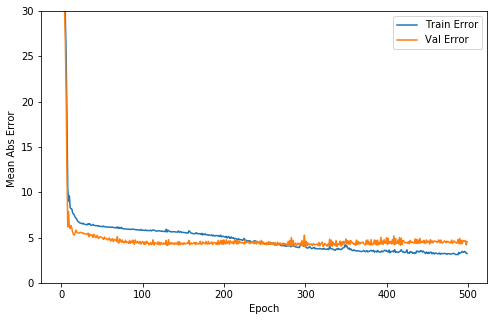

In [70]:
plot_history(history)

PCA 90


In [71]:
start = time.time()
def build_reduced2(input_dim):
    model = keras.Sequential()
    model.add(layers.Conv1D(64, 2, activation='relu', input_shape = (input_dim,1)))
    model.add(layers.Conv1D(64, 2, activation='relu'))
    model.add(layers.Conv1D(64, 2, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model

In [72]:

model_reduced2 = build_reduced2(x_reduced2.shape[1])
model_reduced2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 6, 64)             192       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 64)             8256      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 64)             8256      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [73]:
x_reduced2 = x_reduced2.reshape(x_reduced2.shape[0],x_reduced2.shape[1],1)
history = model_reduced2.fit(x_reduced2, y_train,
                    epochs=500,
                    batch_size=20,
                    validation_split=0.1)

x_reduced_test2 = x_reduced_test2.reshape(x_reduced_test2.shape[0],x_reduced_test2.shape[1],1)
y_predicted = model_reduced2.predict(x_reduced_test2).flatten()

y_predicted

Train on 120 samples, validate on 14 samples
Epoch 1/500
120/120 [==============================] - 1s 6ms/sample - loss: 35.3573 - mean_absolute_error: 35.3573 - val_loss: 34.7349 - val_mean_absolute_error: 34.7349
Epoch 2/500
120/120 [==============================] - 0s 286us/sample - loss: 34.9999 - mean_absolute_error: 34.9999 - val_loss: 34.3460 - val_mean_absolute_error: 34.3460
Epoch 3/500
120/120 [==============================] - 0s 260us/sample - loss: 34.5277 - mean_absolute_error: 34.5277 - val_loss: 33.7469 - val_mean_absolute_error: 33.7469
Epoch 4/500
120/120 [==============================] - 0s 260us/sample - loss: 33.7795 - mean_absolute_error: 33.7795 - val_loss: 32.7483 - val_mean_absolute_error: 32.7483
Epoch 5/500
120/120 [==============================] - 0s 130us/sample - loss: 32.5281 - mean_absolute_error: 32.5281 - val_loss: 31.0553 - val_mean_absolute_error: 31.0553
Epoch 6/500
120/120 [==============================] - 0s 130us/sample - loss: 30.4135 - mea

Epoch 49/500
120/120 [==============================] - 0s 130us/sample - loss: 6.2287 - mean_absolute_error: 6.2287 - val_loss: 5.2658 - val_mean_absolute_error: 5.2658
Epoch 50/500
120/120 [==============================] - 0s 130us/sample - loss: 6.2480 - mean_absolute_error: 6.2480 - val_loss: 5.1999 - val_mean_absolute_error: 5.1999
Epoch 51/500
120/120 [==============================] - 0s 260us/sample - loss: 6.2035 - mean_absolute_error: 6.2035 - val_loss: 5.3413 - val_mean_absolute_error: 5.3413
Epoch 52/500
120/120 [==============================] - 0s 260us/sample - loss: 6.3012 - mean_absolute_error: 6.3012 - val_loss: 5.5338 - val_mean_absolute_error: 5.5338
Epoch 53/500
120/120 [==============================] - 0s 130us/sample - loss: 6.2088 - mean_absolute_error: 6.2088 - val_loss: 5.1968 - val_mean_absolute_error: 5.1968
Epoch 54/500
120/120 [==============================] - 0s 130us/sample - loss: 6.2217 - mean_absolute_error: 6.2217 - val_loss: 5.1507 - val_mean_abs

120/120 [==============================] - 0s 130us/sample - loss: 5.6069 - mean_absolute_error: 5.6069 - val_loss: 5.0560 - val_mean_absolute_error: 5.0560
Epoch 146/500
120/120 [==============================] - 0s 260us/sample - loss: 5.6658 - mean_absolute_error: 5.6658 - val_loss: 5.0744 - val_mean_absolute_error: 5.0744
Epoch 147/500
120/120 [==============================] - 0s 130us/sample - loss: 5.7929 - mean_absolute_error: 5.7929 - val_loss: 5.5674 - val_mean_absolute_error: 5.5674
Epoch 148/500
120/120 [==============================] - 0s 130us/sample - loss: 5.5721 - mean_absolute_error: 5.5721 - val_loss: 5.0668 - val_mean_absolute_error: 5.0668
Epoch 149/500
120/120 [==============================] - 0s 260us/sample - loss: 5.7761 - mean_absolute_error: 5.7761 - val_loss: 5.1276 - val_mean_absolute_error: 5.1276
Epoch 150/500
120/120 [==============================] - 0s 260us/sample - loss: 5.6780 - mean_absolute_error: 5.6780 - val_loss: 5.5316 - val_mean_absolute_er

Epoch 193/500
120/120 [==============================] - 0s 260us/sample - loss: 5.3964 - mean_absolute_error: 5.3964 - val_loss: 5.5765 - val_mean_absolute_error: 5.5765
Epoch 194/500
120/120 [==============================] - 0s 260us/sample - loss: 5.3827 - mean_absolute_error: 5.3827 - val_loss: 5.1352 - val_mean_absolute_error: 5.1352
Epoch 195/500
120/120 [==============================] - 0s 260us/sample - loss: 5.4403 - mean_absolute_error: 5.4403 - val_loss: 5.2042 - val_mean_absolute_error: 5.2042
Epoch 196/500
120/120 [==============================] - 0s 260us/sample - loss: 5.5289 - mean_absolute_error: 5.5289 - val_loss: 5.7108 - val_mean_absolute_error: 5.7108
Epoch 197/500
120/120 [==============================] - 0s 260us/sample - loss: 5.2974 - mean_absolute_error: 5.2974 - val_loss: 5.0395 - val_mean_absolute_error: 5.0395
Epoch 198/500
120/120 [==============================] - 0s 292us/sample - loss: 5.3836 - mean_absolute_error: 5.3836 - val_loss: 5.3305 - val_me

Epoch 241/500
120/120 [==============================] - 0s 260us/sample - loss: 5.0649 - mean_absolute_error: 5.0649 - val_loss: 5.0485 - val_mean_absolute_error: 5.0485
Epoch 242/500
120/120 [==============================] - 0s 130us/sample - loss: 5.1390 - mean_absolute_error: 5.1390 - val_loss: 4.9037 - val_mean_absolute_error: 4.9037
Epoch 243/500
120/120 [==============================] - 0s 130us/sample - loss: 5.0317 - mean_absolute_error: 5.0317 - val_loss: 5.4119 - val_mean_absolute_error: 5.4119
Epoch 244/500
120/120 [==============================] - 0s 260us/sample - loss: 5.0628 - mean_absolute_error: 5.0628 - val_loss: 5.1979 - val_mean_absolute_error: 5.1979
Epoch 245/500
120/120 [==============================] - 0s 260us/sample - loss: 5.0609 - mean_absolute_error: 5.0609 - val_loss: 5.1388 - val_mean_absolute_error: 5.1388
Epoch 246/500
120/120 [==============================] - 0s 130us/sample - loss: 5.0861 - mean_absolute_error: 5.0861 - val_loss: 5.2446 - val_me

Epoch 289/500
120/120 [==============================] - 0s 260us/sample - loss: 4.7552 - mean_absolute_error: 4.7552 - val_loss: 4.7692 - val_mean_absolute_error: 4.7692
Epoch 290/500
120/120 [==============================] - 0s 130us/sample - loss: 4.7125 - mean_absolute_error: 4.7125 - val_loss: 4.6272 - val_mean_absolute_error: 4.6272
Epoch 291/500
120/120 [==============================] - 0s 130us/sample - loss: 4.6398 - mean_absolute_error: 4.6398 - val_loss: 4.8261 - val_mean_absolute_error: 4.8261
Epoch 292/500
120/120 [==============================] - 0s 260us/sample - loss: 4.6572 - mean_absolute_error: 4.6572 - val_loss: 4.6714 - val_mean_absolute_error: 4.6714
Epoch 293/500
120/120 [==============================] - 0s 260us/sample - loss: 4.6332 - mean_absolute_error: 4.6332 - val_loss: 4.7485 - val_mean_absolute_error: 4.7485
Epoch 294/500
120/120 [==============================] - 0s 130us/sample - loss: 4.6134 - mean_absolute_error: 4.6134 - val_loss: 4.9519 - val_me

Epoch 337/500
120/120 [==============================] - 0s 260us/sample - loss: 4.1786 - mean_absolute_error: 4.1786 - val_loss: 4.7273 - val_mean_absolute_error: 4.7273
Epoch 338/500
120/120 [==============================] - 0s 130us/sample - loss: 4.2282 - mean_absolute_error: 4.2282 - val_loss: 4.6426 - val_mean_absolute_error: 4.6426
Epoch 339/500
120/120 [==============================] - 0s 130us/sample - loss: 4.1583 - mean_absolute_error: 4.1583 - val_loss: 4.7737 - val_mean_absolute_error: 4.7737
Epoch 340/500
120/120 [==============================] - 0s 391us/sample - loss: 4.1854 - mean_absolute_error: 4.1854 - val_loss: 4.5941 - val_mean_absolute_error: 4.5941
Epoch 341/500
120/120 [==============================] - 0s 260us/sample - loss: 4.1818 - mean_absolute_error: 4.1818 - val_loss: 4.8584 - val_mean_absolute_error: 4.8584
Epoch 342/500
120/120 [==============================] - 0s 130us/sample - loss: 4.1642 - mean_absolute_error: 4.1642 - val_loss: 4.6492 - val_me

Epoch 385/500
120/120 [==============================] - 0s 260us/sample - loss: 4.0358 - mean_absolute_error: 4.0358 - val_loss: 4.9813 - val_mean_absolute_error: 4.9813
Epoch 386/500
120/120 [==============================] - 0s 254us/sample - loss: 4.0752 - mean_absolute_error: 4.0752 - val_loss: 4.5177 - val_mean_absolute_error: 4.5177
Epoch 387/500
120/120 [==============================] - 0s 138us/sample - loss: 3.9227 - mean_absolute_error: 3.9227 - val_loss: 4.7335 - val_mean_absolute_error: 4.7335
Epoch 388/500
120/120 [==============================] - 0s 130us/sample - loss: 4.0065 - mean_absolute_error: 4.0065 - val_loss: 4.4234 - val_mean_absolute_error: 4.4234
Epoch 389/500
120/120 [==============================] - 0s 130us/sample - loss: 4.0281 - mean_absolute_error: 4.0281 - val_loss: 4.7579 - val_mean_absolute_error: 4.7579
Epoch 390/500
120/120 [==============================] - 0s 260us/sample - loss: 3.9770 - mean_absolute_error: 3.9770 - val_loss: 4.4991 - val_me

Epoch 433/500
120/120 [==============================] - 0s 130us/sample - loss: 3.7617 - mean_absolute_error: 3.7617 - val_loss: 4.3072 - val_mean_absolute_error: 4.3072
Epoch 434/500
120/120 [==============================] - 0s 260us/sample - loss: 3.8095 - mean_absolute_error: 3.8095 - val_loss: 4.0740 - val_mean_absolute_error: 4.0740
Epoch 435/500
120/120 [==============================] - 0s 260us/sample - loss: 4.0646 - mean_absolute_error: 4.0646 - val_loss: 4.1387 - val_mean_absolute_error: 4.1387
Epoch 436/500
120/120 [==============================] - 0s 130us/sample - loss: 3.8007 - mean_absolute_error: 3.8007 - val_loss: 4.3224 - val_mean_absolute_error: 4.3224
Epoch 437/500
120/120 [==============================] - 0s 130us/sample - loss: 3.8050 - mean_absolute_error: 3.8050 - val_loss: 4.0955 - val_mean_absolute_error: 4.0955
Epoch 438/500
120/120 [==============================] - 0s 260us/sample - loss: 3.7665 - mean_absolute_error: 3.7665 - val_loss: 4.3487 - val_me

Epoch 481/500
120/120 [==============================] - 0s 130us/sample - loss: 3.6589 - mean_absolute_error: 3.6589 - val_loss: 4.1457 - val_mean_absolute_error: 4.1457
Epoch 482/500
120/120 [==============================] - 0s 260us/sample - loss: 3.6833 - mean_absolute_error: 3.6833 - val_loss: 4.1063 - val_mean_absolute_error: 4.1063
Epoch 483/500
120/120 [==============================] - 0s 260us/sample - loss: 3.9912 - mean_absolute_error: 3.9912 - val_loss: 4.0341 - val_mean_absolute_error: 4.0341
Epoch 484/500
120/120 [==============================] - 0s 130us/sample - loss: 3.8258 - mean_absolute_error: 3.8258 - val_loss: 3.7704 - val_mean_absolute_error: 3.7704
Epoch 485/500
120/120 [==============================] - 0s 130us/sample - loss: 3.6623 - mean_absolute_error: 3.6623 - val_loss: 4.3831 - val_mean_absolute_error: 4.3831
Epoch 486/500
120/120 [==============================] - 0s 260us/sample - loss: 3.7100 - mean_absolute_error: 3.7100 - val_loss: 3.8048 - val_me

array([44.899887, 40.82837 , 44.252235, 36.868996, 37.20871 , 37.180035,
       22.42851 , 31.19436 , 20.585928, 38.9452  , 32.944252, 37.794624,
       26.314789, 37.218033, 32.231827], dtype=float32)

In [74]:
y_test_array = np.array(y_test)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca 90 - cnn time :", time.time() - start)

0.11846454501696214
pca 90 - cnn time : 17.186609029769897


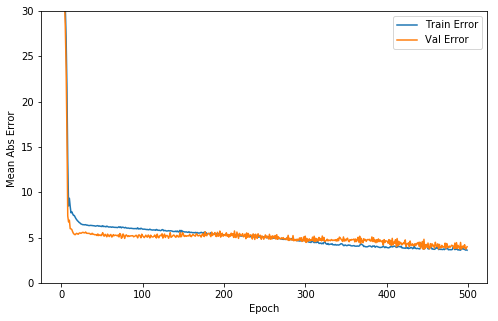

In [75]:
plot_history(history)

정규화된 34개 변수

In [76]:
start = time.time()
def build_no_pca(input_dim):
    model = keras.Sequential()
    model.add(layers.Embedding(15000, 64, input_length= input_dim))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(32, 7, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error'])
    return model

In [77]:
model_no_pca = build_no_pca(x_train_norm.shape[1])
model_no_pca.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 64)            960000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 32)            6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 14, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 32)             7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
__________

In [78]:

history = model_no_pca.fit(x_train_norm, y_train,
                    epochs=500,
                    batch_size=20,
                    validation_split=0.1)

y_predicted = model_no_pca.predict(x_test_norm).flatten()

y_predicted

Train on 120 samples, validate on 14 samples
Epoch 1/500
120/120 [==============================] - 1s 6ms/sample - loss: 35.3740 - mean_absolute_error: 35.3740 - val_loss: 34.8353 - val_mean_absolute_error: 34.8353
Epoch 2/500
120/120 [==============================] - 0s 911us/sample - loss: 35.1204 - mean_absolute_error: 35.1204 - val_loss: 34.4323 - val_mean_absolute_error: 34.4323
Epoch 3/500
120/120 [==============================] - 0s 781us/sample - loss: 34.5248 - mean_absolute_error: 34.5248 - val_loss: 33.5044 - val_mean_absolute_error: 33.5044
Epoch 4/500
120/120 [==============================] - 0s 829us/sample - loss: 33.2018 - mean_absolute_error: 33.2018 - val_loss: 31.4990 - val_mean_absolute_error: 31.4990
Epoch 5/500
120/120 [==============================] - 0s 657us/sample - loss: 30.4197 - mean_absolute_error: 30.4197 - val_loss: 27.3684 - val_mean_absolute_error: 27.3684
Epoch 6/500
120/120 [==============================] - 0s 651us/sample - loss: 24.7986 - mea

Epoch 49/500
120/120 [==============================] - 0s 781us/sample - loss: 6.0895 - mean_absolute_error: 6.0895 - val_loss: 4.7079 - val_mean_absolute_error: 4.7079
Epoch 50/500
120/120 [==============================] - 0s 732us/sample - loss: 5.9460 - mean_absolute_error: 5.9460 - val_loss: 4.9703 - val_mean_absolute_error: 4.9703
Epoch 51/500
120/120 [==============================] - 0s 781us/sample - loss: 5.9607 - mean_absolute_error: 5.9607 - val_loss: 4.6359 - val_mean_absolute_error: 4.6359
Epoch 52/500
120/120 [==============================] - 0s 651us/sample - loss: 5.8456 - mean_absolute_error: 5.8456 - val_loss: 4.6521 - val_mean_absolute_error: 4.6521
Epoch 53/500
120/120 [==============================] - 0s 651us/sample - loss: 5.8149 - mean_absolute_error: 5.8149 - val_loss: 4.6631 - val_mean_absolute_error: 4.6631
Epoch 54/500
120/120 [==============================] - 0s 911us/sample - loss: 5.6929 - mean_absolute_error: 5.6929 - val_loss: 4.7366 - val_mean_abs

120/120 [==============================] - 0s 911us/sample - loss: 5.0216 - mean_absolute_error: 5.0216 - val_loss: 4.5698 - val_mean_absolute_error: 4.5698
Epoch 146/500
120/120 [==============================] - 0s 781us/sample - loss: 5.0168 - mean_absolute_error: 5.0168 - val_loss: 4.5828 - val_mean_absolute_error: 4.5828
Epoch 147/500
120/120 [==============================] - 0s 911us/sample - loss: 4.9249 - mean_absolute_error: 4.9249 - val_loss: 4.5554 - val_mean_absolute_error: 4.5554
Epoch 148/500
120/120 [==============================] - 0s 911us/sample - loss: 4.9466 - mean_absolute_error: 4.9466 - val_loss: 4.5724 - val_mean_absolute_error: 4.5724
Epoch 149/500
120/120 [==============================] - 0s 911us/sample - loss: 5.0407 - mean_absolute_error: 5.0407 - val_loss: 4.4600 - val_mean_absolute_error: 4.4600
Epoch 150/500
120/120 [==============================] - 0s 820us/sample - loss: 4.9689 - mean_absolute_error: 4.9689 - val_loss: 4.7759 - val_mean_absolute_er

Epoch 193/500
120/120 [==============================] - 0s 651us/sample - loss: 4.9730 - mean_absolute_error: 4.9730 - val_loss: 4.3458 - val_mean_absolute_error: 4.3458
Epoch 194/500
120/120 [==============================] - 0s 723us/sample - loss: 4.9884 - mean_absolute_error: 4.9884 - val_loss: 4.4026 - val_mean_absolute_error: 4.4026
Epoch 195/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8825 - mean_absolute_error: 4.8825 - val_loss: 4.4694 - val_mean_absolute_error: 4.4694
Epoch 196/500
120/120 [==============================] - 0s 651us/sample - loss: 4.9654 - mean_absolute_error: 4.9654 - val_loss: 4.4789 - val_mean_absolute_error: 4.4789
Epoch 197/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8923 - mean_absolute_error: 4.8923 - val_loss: 4.4701 - val_mean_absolute_error: 4.4701
Epoch 198/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8566 - mean_absolute_error: 4.8566 - val_loss: 4.4584 - val_me

Epoch 241/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8611 - mean_absolute_error: 4.8611 - val_loss: 4.4493 - val_mean_absolute_error: 4.4493
Epoch 242/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8603 - mean_absolute_error: 4.8603 - val_loss: 4.4239 - val_mean_absolute_error: 4.4239
Epoch 243/500
120/120 [==============================] - 0s 651us/sample - loss: 4.7931 - mean_absolute_error: 4.7931 - val_loss: 4.4191 - val_mean_absolute_error: 4.4191
Epoch 244/500
120/120 [==============================] - 0s 651us/sample - loss: 4.7943 - mean_absolute_error: 4.7943 - val_loss: 4.3723 - val_mean_absolute_error: 4.3723
Epoch 245/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8077 - mean_absolute_error: 4.8077 - val_loss: 4.3640 - val_mean_absolute_error: 4.3640
Epoch 246/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8179 - mean_absolute_error: 4.8179 - val_loss: 4.3901 - val_me

Epoch 289/500
120/120 [==============================] - 0s 651us/sample - loss: 4.7618 - mean_absolute_error: 4.7618 - val_loss: 4.6188 - val_mean_absolute_error: 4.6188
Epoch 290/500
120/120 [==============================] - 0s 651us/sample - loss: 4.7675 - mean_absolute_error: 4.7675 - val_loss: 4.5734 - val_mean_absolute_error: 4.5734
Epoch 291/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8198 - mean_absolute_error: 4.8198 - val_loss: 4.5478 - val_mean_absolute_error: 4.5478
Epoch 292/500
120/120 [==============================] - 0s 651us/sample - loss: 4.8587 - mean_absolute_error: 4.8587 - val_loss: 4.5363 - val_mean_absolute_error: 4.5363
Epoch 293/500
120/120 [==============================] - 0s 651us/sample - loss: 4.9129 - mean_absolute_error: 4.9129 - val_loss: 4.5494 - val_mean_absolute_error: 4.5494
Epoch 294/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6464 - mean_absolute_error: 4.6464 - val_loss: 4.5965 - val_me

Epoch 337/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6723 - mean_absolute_error: 4.6723 - val_loss: 4.7794 - val_mean_absolute_error: 4.7794
Epoch 338/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6086 - mean_absolute_error: 4.6086 - val_loss: 4.7950 - val_mean_absolute_error: 4.7950
Epoch 339/500
120/120 [==============================] - 0s 651us/sample - loss: 4.7491 - mean_absolute_error: 4.7491 - val_loss: 4.9694 - val_mean_absolute_error: 4.9694
Epoch 340/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6936 - mean_absolute_error: 4.6936 - val_loss: 4.7407 - val_mean_absolute_error: 4.7407
Epoch 341/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6974 - mean_absolute_error: 4.6974 - val_loss: 4.7053 - val_mean_absolute_error: 4.7053
Epoch 342/500
120/120 [==============================] - 0s 781us/sample - loss: 4.6681 - mean_absolute_error: 4.6681 - val_loss: 4.7244 - val_me

Epoch 432/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6060 - mean_absolute_error: 4.6060 - val_loss: 5.1232 - val_mean_absolute_error: 5.1232
Epoch 433/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6148 - mean_absolute_error: 4.6148 - val_loss: 5.1827 - val_mean_absolute_error: 5.1827
Epoch 434/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6805 - mean_absolute_error: 4.6805 - val_loss: 5.1635 - val_mean_absolute_error: 5.1635
Epoch 435/500
120/120 [==============================] - 0s 651us/sample - loss: 4.6286 - mean_absolute_error: 4.6286 - val_loss: 5.1485 - val_mean_absolute_error: 5.1485
Epoch 436/500
120/120 [==============================] - 0s 804us/sample - loss: 4.6608 - mean_absolute_error: 4.6608 - val_loss: 5.1318 - val_mean_absolute_error: 5.1318
Epoch 437/500
120/120 [==============================] - 0s 651us/sample - loss: 4.7044 - mean_absolute_error: 4.7044 - val_loss: 5.1828 - val_me

Epoch 480/500
120/120 [==============================] - 0s 651us/sample - loss: 4.5762 - mean_absolute_error: 4.5762 - val_loss: 5.1421 - val_mean_absolute_error: 5.1421
Epoch 481/500
120/120 [==============================] - 0s 651us/sample - loss: 4.5525 - mean_absolute_error: 4.5525 - val_loss: 5.0798 - val_mean_absolute_error: 5.0798
Epoch 482/500
120/120 [==============================] - 0s 743us/sample - loss: 4.6184 - mean_absolute_error: 4.6184 - val_loss: 5.0760 - val_mean_absolute_error: 5.0760
Epoch 483/500
120/120 [==============================] - 0s 651us/sample - loss: 4.5630 - mean_absolute_error: 4.5630 - val_loss: 5.1199 - val_mean_absolute_error: 5.1199
Epoch 484/500
120/120 [==============================] - 0s 651us/sample - loss: 4.5592 - mean_absolute_error: 4.5592 - val_loss: 5.2342 - val_mean_absolute_error: 5.2342
Epoch 485/500
120/120 [==============================] - 0s 651us/sample - loss: 4.5995 - mean_absolute_error: 4.5995 - val_loss: 5.1507 - val_me

array([51.39589 , 41.863064, 35.058807, 36.985077, 33.84441 , 36.25196 ,
       26.431238, 31.60152 , 35.058807, 34.70036 , 33.551964, 31.408749,
       35.058807, 36.25196 , 36.25196 ], dtype=float32)

In [79]:
y_test_array = np.array(y_test)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x - cnn time :", time.time() - start)

0.17203762452054858
pca x - cnn time : 47.04038095474243


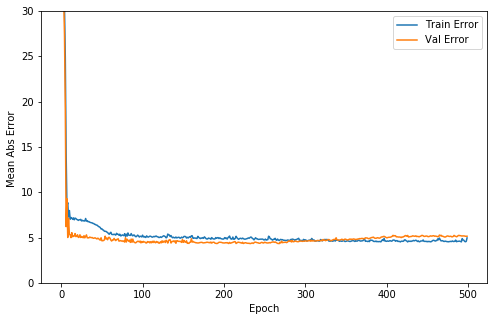

In [80]:
plot_history(history)

most correlated 8 variables

In [81]:
start = time.time()
def build_cnn_corr(input_dim):
    model = keras.Sequential()
    model.add(layers.Embedding(15000, 64, input_length= input_dim))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error'])
    return model

In [82]:
model_corr = build_cnn_corr(x_train_corr.shape[1])
model_corr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 64)             960000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 6, 32)             6176      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 4, 32)             3104      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2, 32)             3104      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 972,417
Trainable params: 972,417
Non-trainable params: 0
_________________________________________________________________


In [83]:

history = model_corr.fit(x_train_corr, y_train,
                    epochs=500,
                    batch_size=20,
                    validation_split=0.1)

y_predicted = model_corr.predict(x_test_corr).flatten()

y_predicted

Train on 120 samples, validate on 14 samples
Epoch 1/500
120/120 [==============================] - 1s 6ms/sample - loss: 35.4335 - mean_absolute_error: 35.4335 - val_loss: 34.9447 - val_mean_absolute_error: 34.9447
Epoch 2/500
120/120 [==============================] - 0s 651us/sample - loss: 35.3141 - mean_absolute_error: 35.3141 - val_loss: 34.7719 - val_mean_absolute_error: 34.7719
Epoch 3/500
120/120 [==============================] - 0s 651us/sample - loss: 35.0772 - mean_absolute_error: 35.0772 - val_loss: 34.4144 - val_mean_absolute_error: 34.4144
Epoch 4/500
120/120 [==============================] - 0s 651us/sample - loss: 34.5745 - mean_absolute_error: 34.5745 - val_loss: 33.6462 - val_mean_absolute_error: 33.6462
Epoch 5/500
120/120 [==============================] - 0s 651us/sample - loss: 33.5162 - mean_absolute_error: 33.5162 - val_loss: 32.0441 - val_mean_absolute_error: 32.0441
Epoch 6/500
120/120 [==============================] - 0s 651us/sample - loss: 31.3133 - mea

Epoch 49/500
120/120 [==============================] - 0s 651us/sample - loss: 6.4161 - mean_absolute_error: 6.4161 - val_loss: 4.9761 - val_mean_absolute_error: 4.9761
Epoch 50/500
120/120 [==============================] - 0s 651us/sample - loss: 6.5233 - mean_absolute_error: 6.5233 - val_loss: 4.7466 - val_mean_absolute_error: 4.7466
Epoch 51/500
120/120 [==============================] - 0s 651us/sample - loss: 6.5530 - mean_absolute_error: 6.5530 - val_loss: 4.8245 - val_mean_absolute_error: 4.8245
Epoch 52/500
120/120 [==============================] - 0s 521us/sample - loss: 6.5882 - mean_absolute_error: 6.5882 - val_loss: 4.9155 - val_mean_absolute_error: 4.9155
Epoch 53/500
120/120 [==============================] - 0s 521us/sample - loss: 6.3357 - mean_absolute_error: 6.3357 - val_loss: 4.6895 - val_mean_absolute_error: 4.6895
Epoch 54/500
120/120 [==============================] - 0s 651us/sample - loss: 6.5642 - mean_absolute_error: 6.5642 - val_loss: 4.9713 - val_mean_abs

120/120 [==============================] - 0s 651us/sample - loss: 6.3676 - mean_absolute_error: 6.3676 - val_loss: 4.5590 - val_mean_absolute_error: 4.5590
Epoch 146/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2269 - mean_absolute_error: 6.2269 - val_loss: 4.5798 - val_mean_absolute_error: 4.5798
Epoch 147/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2648 - mean_absolute_error: 6.2648 - val_loss: 4.7842 - val_mean_absolute_error: 4.7842
Epoch 148/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2542 - mean_absolute_error: 6.2542 - val_loss: 4.7898 - val_mean_absolute_error: 4.7898
Epoch 149/500
120/120 [==============================] - 0s 651us/sample - loss: 6.3996 - mean_absolute_error: 6.3996 - val_loss: 4.6437 - val_mean_absolute_error: 4.6437
Epoch 150/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1979 - mean_absolute_error: 6.1979 - val_loss: 4.6556 - val_mean_absolute_er

Epoch 193/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2246 - mean_absolute_error: 6.2246 - val_loss: 4.6107 - val_mean_absolute_error: 4.6107
Epoch 194/500
120/120 [==============================] - 0s 646us/sample - loss: 6.2620 - mean_absolute_error: 6.2620 - val_loss: 4.5784 - val_mean_absolute_error: 4.5784
Epoch 195/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2134 - mean_absolute_error: 6.2134 - val_loss: 4.5804 - val_mean_absolute_error: 4.5804
Epoch 196/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2492 - mean_absolute_error: 6.2492 - val_loss: 4.5994 - val_mean_absolute_error: 4.5994
Epoch 197/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2031 - mean_absolute_error: 6.2031 - val_loss: 4.6089 - val_mean_absolute_error: 4.6089
Epoch 198/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1995 - mean_absolute_error: 6.1995 - val_loss: 4.6023 - val_me

Epoch 241/500
120/120 [==============================] - 0s 651us/sample - loss: 6.3846 - mean_absolute_error: 6.3846 - val_loss: 4.6618 - val_mean_absolute_error: 4.6618
Epoch 242/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2364 - mean_absolute_error: 6.2364 - val_loss: 4.7060 - val_mean_absolute_error: 4.7060
Epoch 243/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2375 - mean_absolute_error: 6.2375 - val_loss: 4.6927 - val_mean_absolute_error: 4.6927
Epoch 244/500
120/120 [==============================] - 0s 708us/sample - loss: 6.2555 - mean_absolute_error: 6.2555 - val_loss: 4.6288 - val_mean_absolute_error: 4.6288
Epoch 245/500
120/120 [==============================] - 0s 651us/sample - loss: 6.3009 - mean_absolute_error: 6.3009 - val_loss: 4.5867 - val_mean_absolute_error: 4.5867
Epoch 246/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1885 - mean_absolute_error: 6.1885 - val_loss: 4.5958 - val_me

Epoch 289/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2331 - mean_absolute_error: 6.2331 - val_loss: 4.5867 - val_mean_absolute_error: 4.5867
Epoch 290/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1930 - mean_absolute_error: 6.1930 - val_loss: 4.6582 - val_mean_absolute_error: 4.6582
Epoch 291/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1857 - mean_absolute_error: 6.1857 - val_loss: 4.5860 - val_mean_absolute_error: 4.5860
Epoch 292/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1779 - mean_absolute_error: 6.1779 - val_loss: 4.5936 - val_mean_absolute_error: 4.5936
Epoch 293/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1965 - mean_absolute_error: 6.1965 - val_loss: 4.6190 - val_mean_absolute_error: 4.6190
Epoch 294/500
120/120 [==============================] - 0s 654us/sample - loss: 6.1808 - mean_absolute_error: 6.1808 - val_loss: 4.6117 - val_me

Epoch 337/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2059 - mean_absolute_error: 6.2059 - val_loss: 4.5627 - val_mean_absolute_error: 4.5627
Epoch 338/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1811 - mean_absolute_error: 6.1811 - val_loss: 4.5555 - val_mean_absolute_error: 4.5555
Epoch 339/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2050 - mean_absolute_error: 6.2050 - val_loss: 4.5714 - val_mean_absolute_error: 4.5714
Epoch 340/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1857 - mean_absolute_error: 6.1857 - val_loss: 4.6461 - val_mean_absolute_error: 4.6461
Epoch 341/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1755 - mean_absolute_error: 6.1755 - val_loss: 4.6090 - val_mean_absolute_error: 4.6090
Epoch 342/500
120/120 [==============================] - 0s 761us/sample - loss: 6.2146 - mean_absolute_error: 6.2146 - val_loss: 4.6029 - val_me

Epoch 385/500
120/120 [==============================] - 0s 781us/sample - loss: 6.2487 - mean_absolute_error: 6.2487 - val_loss: 4.8590 - val_mean_absolute_error: 4.8590
Epoch 386/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2668 - mean_absolute_error: 6.2668 - val_loss: 4.5647 - val_mean_absolute_error: 4.5647
Epoch 387/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1481 - mean_absolute_error: 6.1481 - val_loss: 4.6143 - val_mean_absolute_error: 4.6143
Epoch 388/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1820 - mean_absolute_error: 6.1820 - val_loss: 4.6270 - val_mean_absolute_error: 4.6270
Epoch 389/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1765 - mean_absolute_error: 6.1765 - val_loss: 4.5966 - val_mean_absolute_error: 4.5966
Epoch 390/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1583 - mean_absolute_error: 6.1583 - val_loss: 4.6190 - val_me

Epoch 433/500
120/120 [==============================] - 0s 651us/sample - loss: 6.0998 - mean_absolute_error: 6.0998 - val_loss: 4.6119 - val_mean_absolute_error: 4.6119
Epoch 434/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1151 - mean_absolute_error: 6.1151 - val_loss: 4.5744 - val_mean_absolute_error: 4.5744
Epoch 435/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1473 - mean_absolute_error: 6.1473 - val_loss: 4.6549 - val_mean_absolute_error: 4.6549
Epoch 436/500
120/120 [==============================] - 0s 651us/sample - loss: 6.2007 - mean_absolute_error: 6.2007 - val_loss: 4.6954 - val_mean_absolute_error: 4.6954
Epoch 437/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1505 - mean_absolute_error: 6.1505 - val_loss: 4.6368 - val_mean_absolute_error: 4.6368
Epoch 438/500
120/120 [==============================] - 0s 730us/sample - loss: 6.1504 - mean_absolute_error: 6.1504 - val_loss: 4.5803 - val_me

Epoch 481/500
120/120 [==============================] - 0s 781us/sample - loss: 6.1663 - mean_absolute_error: 6.1663 - val_loss: 4.7920 - val_mean_absolute_error: 4.7920
Epoch 482/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1207 - mean_absolute_error: 6.1207 - val_loss: 4.6437 - val_mean_absolute_error: 4.6437
Epoch 483/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1353 - mean_absolute_error: 6.1353 - val_loss: 4.6567 - val_mean_absolute_error: 4.6567
Epoch 484/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1771 - mean_absolute_error: 6.1771 - val_loss: 4.7056 - val_mean_absolute_error: 4.7056
Epoch 485/500
120/120 [==============================] - 0s 651us/sample - loss: 6.0611 - mean_absolute_error: 6.0611 - val_loss: 4.6530 - val_mean_absolute_error: 4.6530
Epoch 486/500
120/120 [==============================] - 0s 651us/sample - loss: 6.1318 - mean_absolute_error: 6.1318 - val_loss: 4.6347 - val_me

array([36.244606, 36.717285, 36.244606, 36.717285, 36.244606, 36.717285,
       36.244606, 36.717285, 36.244606, 36.9533  , 36.244606, 36.244606,
       36.244606, 36.717285, 36.717285], dtype=float32)

In [84]:
y_test_array = np.array(y_test)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("8 var - cnn time :", time.time() - start)

0.247776976022759
8 var - cnn time : 43.818639278411865


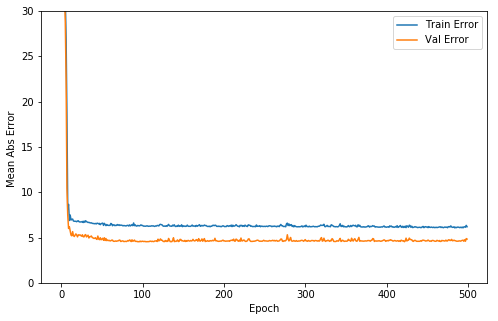

In [85]:
plot_history(history)

In [86]:
start = time.time()

def build_cnn(input_dim):
    model = keras.Sequential()
    model.add(layers.Embedding(15000, 64, input_length= input_dim))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(32, 7, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error'])
    return model

기존 34개변수

In [87]:
model = build_cnn(x_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 34, 64)            960000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 32, 32)            6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 14, 32)            3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1, 32)             7200      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
__________

In [88]:

history = model.fit(x_train, y_train,
                    epochs=500,
                    batch_size=20,
                    validation_split=0.1)

y_predicted = model.predict(x_test).flatten()

y_predicted

Train on 120 samples, validate on 14 samples
Epoch 1/500
120/120 [==============================] - 1s 6ms/sample - loss: 35.4378 - mean_absolute_error: 35.4378 - val_loss: 34.9120 - val_mean_absolute_error: 34.9120
Epoch 2/500
120/120 [==============================] - 0s 651us/sample - loss: 35.2411 - mean_absolute_error: 35.2411 - val_loss: 34.6128 - val_mean_absolute_error: 34.6128
Epoch 3/500
120/120 [==============================] - 0s 651us/sample - loss: 34.7848 - mean_absolute_error: 34.7848 - val_loss: 33.8563 - val_mean_absolute_error: 33.8563
Epoch 4/500
120/120 [==============================] - 0s 651us/sample - loss: 33.6610 - mean_absolute_error: 33.6610 - val_loss: 32.0276 - val_mean_absolute_error: 32.0276
Epoch 5/500
120/120 [==============================] - 0s 651us/sample - loss: 31.0089 - mean_absolute_error: 31.0089 - val_loss: 27.7923 - val_mean_absolute_error: 27.7923
Epoch 6/500
120/120 [==============================] - 0s 651us/sample - loss: 24.9733 - mea

Epoch 49/500
120/120 [==============================] - 0s 781us/sample - loss: 2.1982 - mean_absolute_error: 2.1982 - val_loss: 3.4970 - val_mean_absolute_error: 3.4970
Epoch 50/500
120/120 [==============================] - 0s 651us/sample - loss: 2.1095 - mean_absolute_error: 2.1095 - val_loss: 3.4213 - val_mean_absolute_error: 3.4213
Epoch 51/500
120/120 [==============================] - 0s 651us/sample - loss: 2.0853 - mean_absolute_error: 2.0853 - val_loss: 3.4971 - val_mean_absolute_error: 3.4971
Epoch 52/500
120/120 [==============================] - 0s 781us/sample - loss: 2.1038 - mean_absolute_error: 2.1038 - val_loss: 3.8660 - val_mean_absolute_error: 3.8660
Epoch 53/500
120/120 [==============================] - 0s 651us/sample - loss: 2.2640 - mean_absolute_error: 2.2640 - val_loss: 3.8915 - val_mean_absolute_error: 3.8915
Epoch 54/500
120/120 [==============================] - 0s 643us/sample - loss: 2.0903 - mean_absolute_error: 2.0903 - val_loss: 3.6410 - val_mean_abs

120/120 [==============================] - 0s 675us/sample - loss: 0.9165 - mean_absolute_error: 0.9165 - val_loss: 4.2585 - val_mean_absolute_error: 4.2585
Epoch 146/500
120/120 [==============================] - 0s 774us/sample - loss: 0.9430 - mean_absolute_error: 0.9430 - val_loss: 4.1416 - val_mean_absolute_error: 4.1416
Epoch 147/500
120/120 [==============================] - 0s 651us/sample - loss: 0.8411 - mean_absolute_error: 0.8411 - val_loss: 4.1944 - val_mean_absolute_error: 4.1944
Epoch 148/500
120/120 [==============================] - 0s 651us/sample - loss: 0.7676 - mean_absolute_error: 0.7676 - val_loss: 4.1147 - val_mean_absolute_error: 4.1147
Epoch 149/500
120/120 [==============================] - 0s 781us/sample - loss: 0.8777 - mean_absolute_error: 0.8777 - val_loss: 3.8306 - val_mean_absolute_error: 3.8306
Epoch 150/500
120/120 [==============================] - 0s 651us/sample - loss: 0.9807 - mean_absolute_error: 0.9807 - val_loss: 3.9954 - val_mean_absolute_er

Epoch 193/500
120/120 [==============================] - 0s 651us/sample - loss: 0.6208 - mean_absolute_error: 0.6208 - val_loss: 3.9784 - val_mean_absolute_error: 3.9784
Epoch 194/500
120/120 [==============================] - 0s 651us/sample - loss: 0.5593 - mean_absolute_error: 0.5593 - val_loss: 4.2214 - val_mean_absolute_error: 4.2214
Epoch 195/500
120/120 [==============================] - 0s 651us/sample - loss: 0.6130 - mean_absolute_error: 0.6130 - val_loss: 4.1576 - val_mean_absolute_error: 4.1576
Epoch 196/500
120/120 [==============================] - 0s 651us/sample - loss: 0.5826 - mean_absolute_error: 0.5826 - val_loss: 4.0322 - val_mean_absolute_error: 4.0322
Epoch 197/500
120/120 [==============================] - 0s 651us/sample - loss: 0.6077 - mean_absolute_error: 0.6077 - val_loss: 4.0102 - val_mean_absolute_error: 4.0102
Epoch 198/500
120/120 [==============================] - 0s 781us/sample - loss: 0.5947 - mean_absolute_error: 0.5947 - val_loss: 4.0932 - val_me

Epoch 241/500
120/120 [==============================] - 0s 651us/sample - loss: 0.4166 - mean_absolute_error: 0.4166 - val_loss: 4.1639 - val_mean_absolute_error: 4.1639
Epoch 242/500
120/120 [==============================] - 0s 781us/sample - loss: 0.3822 - mean_absolute_error: 0.3822 - val_loss: 4.1382 - val_mean_absolute_error: 4.1382
Epoch 243/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3971 - mean_absolute_error: 0.3971 - val_loss: 4.2606 - val_mean_absolute_error: 4.2606
Epoch 244/500
120/120 [==============================] - 0s 651us/sample - loss: 0.4744 - mean_absolute_error: 0.4744 - val_loss: 4.2622 - val_mean_absolute_error: 4.2622
Epoch 245/500
120/120 [==============================] - 0s 651us/sample - loss: 0.4848 - mean_absolute_error: 0.4848 - val_loss: 4.1310 - val_mean_absolute_error: 4.1310
Epoch 246/500
120/120 [==============================] - 0s 651us/sample - loss: 0.5918 - mean_absolute_error: 0.5918 - val_loss: 4.2349 - val_me

Epoch 336/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3500 - mean_absolute_error: 0.3500 - val_loss: 4.1130 - val_mean_absolute_error: 4.1130
Epoch 337/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3307 - mean_absolute_error: 0.3307 - val_loss: 4.0841 - val_mean_absolute_error: 4.0841
Epoch 338/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3346 - mean_absolute_error: 0.3346 - val_loss: 4.0813 - val_mean_absolute_error: 4.0813
Epoch 339/500
120/120 [==============================] - 0s 799us/sample - loss: 0.3062 - mean_absolute_error: 0.3062 - val_loss: 4.0401 - val_mean_absolute_error: 4.0401
Epoch 340/500
120/120 [==============================] - 0s 651us/sample - loss: 0.2822 - mean_absolute_error: 0.2822 - val_loss: 4.0693 - val_mean_absolute_error: 4.0693
Epoch 341/500
120/120 [==============================] - 0s 651us/sample - loss: 0.2891 - mean_absolute_error: 0.2891 - val_loss: 4.1339 - val_me

Epoch 384/500
120/120 [==============================] - 0s 651us/sample - loss: 0.2485 - mean_absolute_error: 0.2485 - val_loss: 4.0887 - val_mean_absolute_error: 4.0887
Epoch 385/500
120/120 [==============================] - 0s 627us/sample - loss: 0.2256 - mean_absolute_error: 0.2256 - val_loss: 4.0709 - val_mean_absolute_error: 4.0709
Epoch 386/500
120/120 [==============================] - 0s 651us/sample - loss: 0.2574 - mean_absolute_error: 0.2574 - val_loss: 4.0807 - val_mean_absolute_error: 4.0807
Epoch 387/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3693 - mean_absolute_error: 0.3693 - val_loss: 4.1019 - val_mean_absolute_error: 4.1019
Epoch 388/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3689 - mean_absolute_error: 0.3689 - val_loss: 4.0357 - val_mean_absolute_error: 4.0357
Epoch 389/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3768 - mean_absolute_error: 0.3768 - val_loss: 4.0084 - val_me

Epoch 432/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3053 - mean_absolute_error: 0.3053 - val_loss: 4.1159 - val_mean_absolute_error: 4.1159
Epoch 433/500
120/120 [==============================] - 0s 651us/sample - loss: 0.2447 - mean_absolute_error: 0.2447 - val_loss: 4.2421 - val_mean_absolute_error: 4.2421
Epoch 434/500
120/120 [==============================] - 0s 651us/sample - loss: 0.2475 - mean_absolute_error: 0.2475 - val_loss: 4.0535 - val_mean_absolute_error: 4.0535
Epoch 435/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3135 - mean_absolute_error: 0.3135 - val_loss: 4.0408 - val_mean_absolute_error: 4.0408
Epoch 436/500
120/120 [==============================] - 0s 651us/sample - loss: 0.2913 - mean_absolute_error: 0.2913 - val_loss: 4.1800 - val_mean_absolute_error: 4.1800
Epoch 437/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3541 - mean_absolute_error: 0.3541 - val_loss: 4.2849 - val_me

Epoch 480/500
120/120 [==============================] - 0s 911us/sample - loss: 0.3140 - mean_absolute_error: 0.3140 - val_loss: 4.0424 - val_mean_absolute_error: 4.0424
Epoch 481/500
120/120 [==============================] - 0s 781us/sample - loss: 0.2586 - mean_absolute_error: 0.2586 - val_loss: 4.1095 - val_mean_absolute_error: 4.1095
Epoch 482/500
120/120 [==============================] - 0s 781us/sample - loss: 0.2608 - mean_absolute_error: 0.2608 - val_loss: 4.1727 - val_mean_absolute_error: 4.1727
Epoch 483/500
120/120 [==============================] - 0s 707us/sample - loss: 0.2802 - mean_absolute_error: 0.2802 - val_loss: 4.1364 - val_mean_absolute_error: 4.1364
Epoch 484/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3317 - mean_absolute_error: 0.3317 - val_loss: 4.1539 - val_mean_absolute_error: 4.1539
Epoch 485/500
120/120 [==============================] - 0s 651us/sample - loss: 0.3311 - mean_absolute_error: 0.3311 - val_loss: 4.1202 - val_me

array([48.94539 , 43.233448, 37.153934, 33.901928, 31.391739, 37.819138,
       31.762314, 37.50968 , 18.55974 , 41.383457, 31.373095, 36.01121 ,
       34.428043, 37.916767, 31.626425], dtype=float32)

In [89]:
y_test_array = np.array(y_test)
score = []
for i in range(len(y_predicted)):
    score.append(np.abs(y_predicted[i] - y_test_array[i])/y_test_array[i])
print(np.array(score).mean())
print("pca x norm x - cnn time :", time.time() - start)

0.12419462838670953
pca x norm x - cnn time : 46.99408006668091


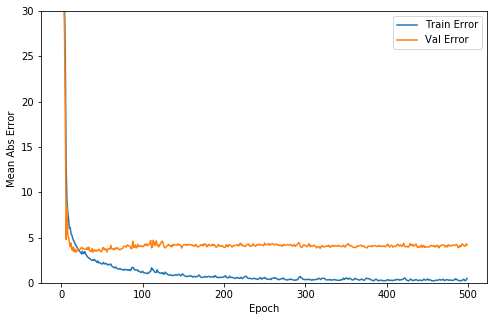

In [90]:
plot_history(history)

In [91]:
print(time.time()-start_time)

437.219033241272
